## 1. Config

In [1]:
# Sys libs
import os

# Data wrangling and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Custom transformers
from preprocessing.imputers import SimpleImputerDF
from preprocessing.feature_extraction import FeatureExtractor
from preprocessing.transformers import OneHotEncoderDF, LogTransformerDF, OrdinalEncoderDF

# Data preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Clustering and dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

# Metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error

# Pytorch datasets and models
import torch
from models.datasets import UsersProfilesDataset
from models.models import ProfileClassifier

In [2]:
DATA_DIRECTORY = './data'
PERSONALITY_FILE_PATH = os.path.join(DATA_DIRECTORY, 'data science task personality.csv')
USERS_FILE_PATH = os.path.join(DATA_DIRECTORY, 'data science task users.csv')

RANDOM_STATE = 42

TEST_SIZE = 0.2

## 2. Data loading

In [3]:
df_p = pd.read_csv(PERSONALITY_FILE_PATH)

df_p.head()

,UserIdentifier,A,B,C,D,E
0,d2d10f362bb1d0092174a660778cbe50,0.041197,-0.389188,-0.257404,0.732678,-0.769127
1,083a56a91d0d1ee4e66643849133b2b3,-0.596461,0.620304,-0.611045,-0.256928,-0.244441
2,fdc1004b329f2aca4c81ad59c93c1be0,-1.198166,-0.821102,0.298394,-0.031738,0.821793
3,8b8a4372a0f3fd3e1a1d4c531211506e,-0.344910,-1.611630,0.220709,-0.323851,-0.127276
4,58d0c701bf73a5949e2ee29f387fb5a2,-0.365047,1.094319,-0.187957,-0.254589,0.554409


In [4]:
df_u = pd.read_csv(USERS_FILE_PATH)

df_u.head()

,UserIdentifier,UserBrowser,D01,D02,D03,D04,D05,D06,D07
0,d2d10f362bb1d0092174a660778cbe50,Firefox 69.0 (Desktop),M,1954.0,3.0,4.0,2.0,6.0,2.0
1,083a56a91d0d1ee4e66643849133b2b3,Chrome 70.0.3538.110 (Mobile),M,1963.0,2.0,2.0,2.0,7.0,2.0
2,fdc1004b329f2aca4c81ad59c93c1be0,Chrome 77.0.3865.90 (Desktop),K,1975.0,4.0,1.0,4.0,5.0,6.0
3,8b8a4372a0f3fd3e1a1d4c531211506e,Chrome 75.0.3770.142 (Desktop),K,1991.0,3.0,2.0,4.0,5.0,4.0
4,58d0c701bf73a5949e2ee29f387fb5a2,Chrome 78.0.3904.108 (Mobile),M,2000.0,3.0,3.0,1.0,7.0,6.0


## 3. Base data quality checks

In [5]:
print(f'DataFrame personality: \n', 30*'-')
print(f'shape: {df_p.shape}')
print(f'distinct UserIdentifier: {len(set(df_p.UserIdentifier))}')
print(f'null values: \n{np.sum(df_p.isnull())}')

print(f'\nDataFrame users: \n', 30*'-')
print(f'shape: {df_u.shape}')
print(f'distinct UserIdentifier: {len(set(df_u.UserIdentifier))}')
print(f'null values: \n{np.sum(df_u.isnull())}')

DataFrame personality: 
 ------------------------------
shape: (1681, 6)
distinct UserIdentifier: 1521
null values: 
UserIdentifier     0
A                  4
B                 10
C                 13
D                  5
E                  5
dtype: int64

DataFrame users: 
 ------------------------------
shape: (1868, 9)
distinct UserIdentifier: 1679
null values: 
UserIdentifier    0
UserBrowser       0
D01               0
D02               0
D03               0
D04               0
D05               1
D06               1
D07               1
dtype: int64


Based on results above we have to deal with:
- duplicates in data
- not consistent datasets (there are users without psychological profiles or otherwise)
- missing values

## 4. Preprocessing

### 4.1 Drop duplicates

Due to fact that we have no knowledge about origin of the data and gathering methods, we have to decide on dropping duplicates - we keep first row per UserIdentifier.

In [6]:
df_p_unique = df_p.drop_duplicates(keep='first').set_index('UserIdentifier')
df_u_unique = df_u.drop_duplicates(keep='first').set_index('UserIdentifier')

### 4.2 Merge sets

In [7]:
df_all = pd.merge(
    left=df_u_unique,
    right=df_p_unique,
    how='inner',
    left_index=True,
    right_index=True
)
df_all.shape

(1537, 13)

Let's investigate types of missing values that we have to deal with

In [8]:
df_all[df_all.isnull().any(axis=1)]

,UserBrowser,D01,D02,D03,D04,D05,D06,D07,A,B,C,D,E
UserIdentifier,,,,,,,,,,,,,
09edb26fcb460c4f96468aa31dc0dd06,Safari 604.1 (Mobile),K,1982.0,4.0,2.0,3.0,7.0,4.0,0.109802,0.732168,-0.572645,-0.055558,NaN
1c701efaaa4758f01323663068da14ea,Chrome 75.0.3770.143 (Mobile),K,1979.0,3.0,2.0,2.0,8.0,2.0,1.024001,1.050683,0.284291,-0.274468,NaN
32de82795acac5c5031f8413aed1caee,Chrome 78.0.3904.96 (Mobile),K,1982.0,3.0,2.0,5.0,4.0,1.0,NaN,-0.791416,1.363351,0.335584,0.516969
33db94f31ad66edf0f5a1b146e82fc29,Chrome 79.0.3945.136 (Mobile),K,1992.0,3.0,7.0,4.0,5.0,4.0,2.548819,0.292757,NaN,0.290557,-0.909705
3652c495d05a4422ee100c4a5b4a2e79,Chrome 78.0.3904.108 (Mobile),K,1998.0,3.0,3.0,3.0,7.0,4.0,0.470677,NaN,0.880579,0.755473,0.174961
385e7c4a548e0cc7430265852959b37c,Chrome 80.0.3987.106 (Desktop),K,2001.0,3.0,3.0,3.0,6.0,3.0,0.898997,0.973255,1.621190,-0.388284,NaN
3df1c502bec4e0443fbcaa9c7b658437,Chrome 78.0.3904.108 (Desktop),K,1989.0,4.0,5.0,1.0,8.0,4.0,-0.619686,0.171983,-0.137237,-0.395190,NaN
3f595d0a1d74fcdf69b0bfb3fcd293ee,Chrome 78.0.3904.108 (Desktop),M,1975.0,4.0,2.0,5.0,6.0,4.0,0.332528,NaN,-1.564114,0.192938,-0.528765
42f9259806bc078a0b018c87302b6bc6,Chrome 79.0.3945.79 (Desktop),K,2001.0,1.0,3.0,4.0,7.0,6.0,-0.307159,-0.294126,NaN,0.651088,-0.612112


### 4.3 Train/test split

To answer the question about connection between those two datasets we have to prove it on both train and test datasets.

In [9]:
users_train, users_test, profiles_train, profiles_test = train_test_split(
    df_all[df_u_unique.columns],
    df_all[df_p_unique.columns],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

### 4.4 Data imputation

In [10]:
profiles_train[profiles_train.isnull().any(axis=1)]

,A,B,C,D,E
UserIdentifier,,,,,
a9708dbcb21aa7ccf7ce2de45cf9f206,0.520347,-0.212977,NaN,-0.608439,-0.664933
b1480f2ce3651ed9866669cbc880dc41,-1.681282,NaN,0.045480,-0.524182,-0.335396
f1b45ed1bcbd980516467cd1754bd684,1.069246,-0.414122,NaN,0.354387,0.026019
1c701efaaa4758f01323663068da14ea,1.024001,1.050683,0.284291,-0.274468,NaN
9d0bdf87380a339c1b566b03b939bb7a,-1.590378,-0.470597,NaN,-0.256888,-0.341710
acf3b39275e90bfe6a5d317a1aed8c59,-0.074913,0.485666,NaN,-0.293493,1.124566
e384956c34ae245c0260f36cd325c1fa,-1.211774,-0.971555,NaN,0.612637,0.065842
c45672e850e1578e1f0af3c4b3dae126,1.493128,NaN,-0.116965,0.178205,-0.099247
33db94f31ad66edf0f5a1b146e82fc29,2.548819,0.292757,NaN,0.290557,-0.909705


We have no business/domain information about those missing values. It can be lack of availability or error in gathering/processing that data. In this case it's hard to make a good decision how to impute those values. We have decided to fill it with value 0.

In [11]:
imputer_profiles = SimpleImputerDF(strategy='constant', fill_value_num=0.0)

profiles_train = imputer_profiles.fit_transform(profiles_train) 

In [12]:
users_train[users_train.isnull().any(axis=1)]

,UserBrowser,D01,D02,D03,D04,D05,D06,D07
UserIdentifier,,,,,,,,


There's no missing values in users's demographic data after we inner joined both datasets.

## 5. Preprocessing

### 5.1 Config

In [13]:
# Features with high number of classes - frequency or ranking encoding
feature_list_freq_encoding = [
    'browser_version'
]

# Nominal/Ordinal features to one hot encoding
feature_list_one_hot_encoding = [
    'D01',
    'D03',
    'D04',
    'D05',
    'browser_name',
    'device_type'
]
# Continuous/Ordinal features to log-scaling
feature_list_log_scaling = [
    'D06',
    'D07',
    'age'
]

We have no dictionary for all of those features (like profession status) so we have to make some assumptions about meaning of that data. In this case only few of those ordinal/nominal features won't be one-hot encoded and treated like continuous values. That config was based on EDA located in chapter 5.3.

### 5.2 Extraction of features

We extract additional features from browser's/device fingerprint and date of birth.

In [14]:
feature_extractor = FeatureExtractor(n_jobs=-1)
users_train = feature_extractor.fit_transform(users_train)

users_train.head()

,D01,D03,D04,D05,D06,D07,browser_name,browser_version,device_type,age
UserIdentifier,,,,,,,,,,
884734cc79af3a9d5eac08b4cb14efb3,M,1.0,7.0,1.0,6.0,6.0,Chrome,79.000394,Desktop,16
dbdcc67a12c0039ce96b42d4c4397733,K,3.0,2.0,1.0,3.0,4.0,Chrome,78.000391,Desktop,35
0c143e8f09fdb6b7b1f5df1535614952,K,4.0,2.0,4.0,4.0,4.0,Chrome,78.000390,Mobile,39
ed30cab21465b19fbd596a0e4f1affa9,M,3.0,2.0,1.0,6.0,6.0,Chrome,78.000390,Desktop,23
3b8128ec47598abedd45be569010cf29,K,3.0,6.0,4.0,1.0,2.0,Firefox,71.000000,Desktop,21


### 5.3 Brief EDA of features

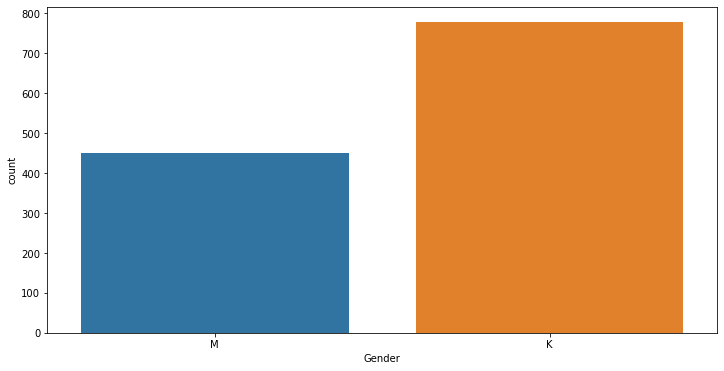

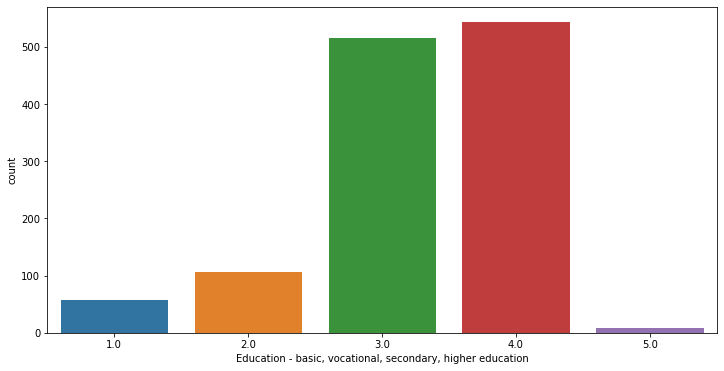

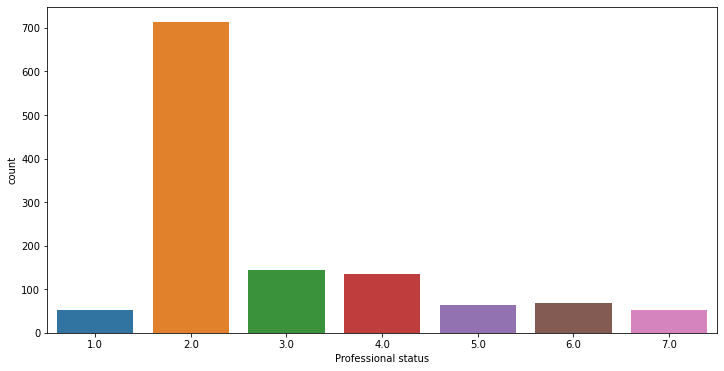

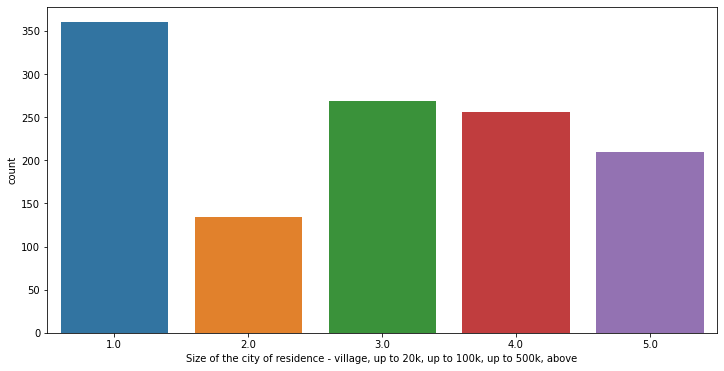

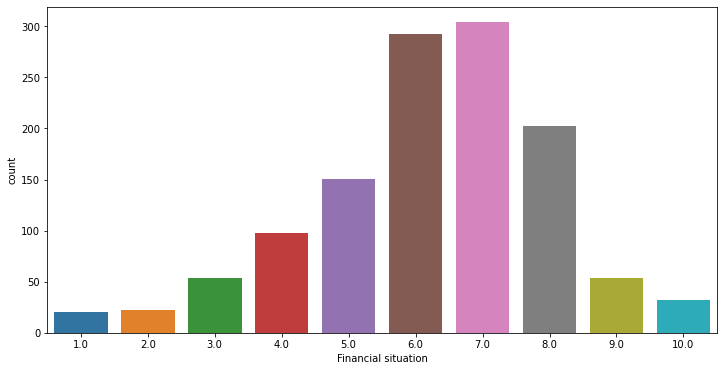

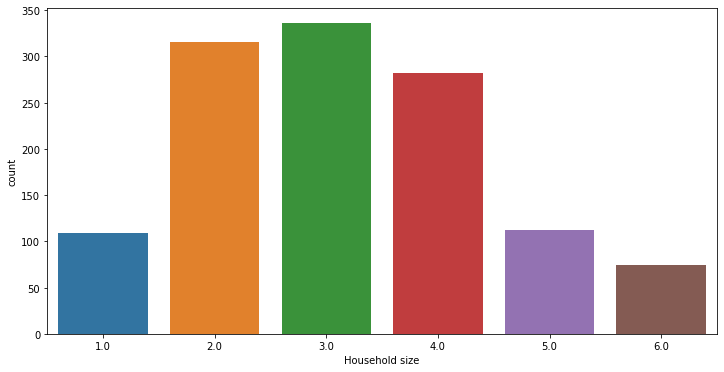

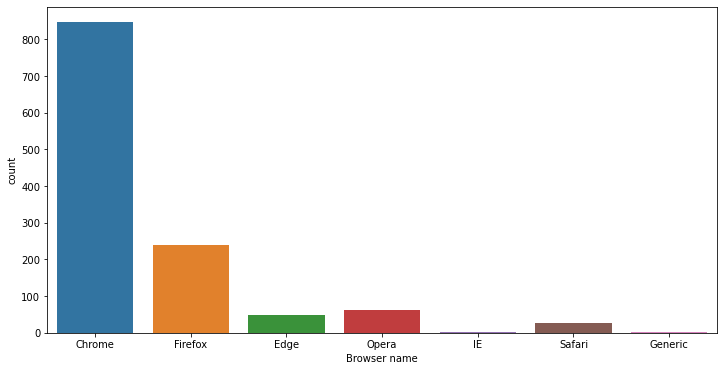

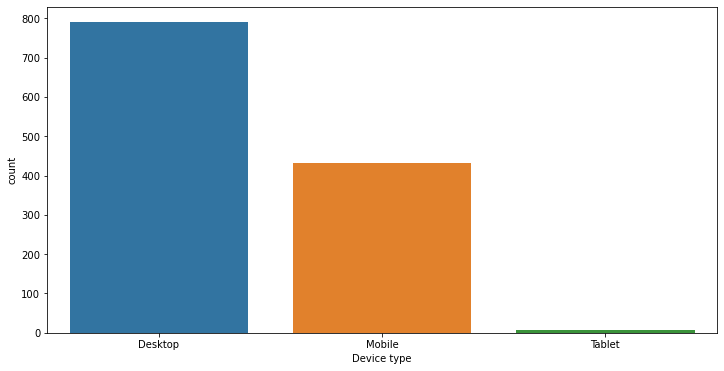

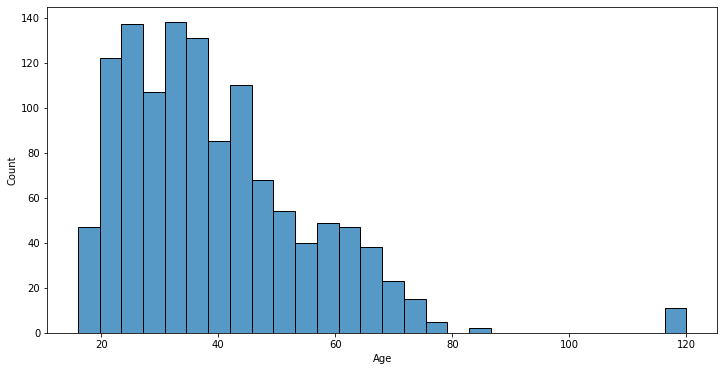

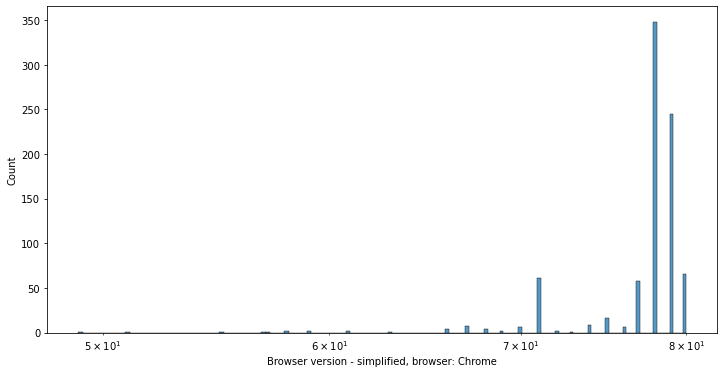

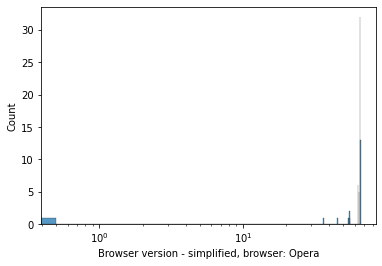

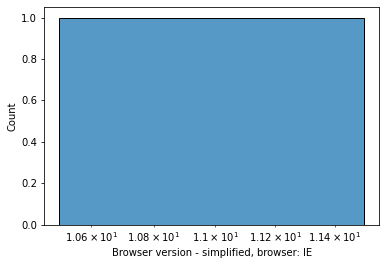

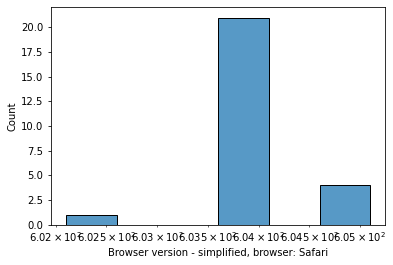

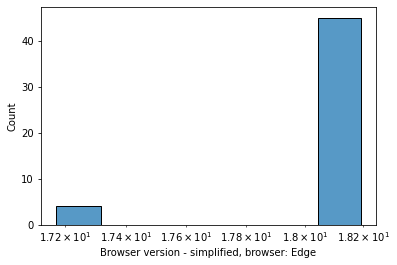

In [15]:
col_config = {
    'categorical': {
        'D01': 'Gender',
        'D03': 'Education - basic, vocational, secondary, higher education',
        'D04': 'Professional status',
        'D05': 'Size of the city of residence - village, up to 20k, up to 100k, up to 500k, above',
        'D06': 'Financial situation',
        'D07': 'Household size',
        'browser_name': 'Browser name',
        'device_type': 'Device type'
    },
    'continuous': {
        'age': 'Age',
        'browser_version': 'Browser version - simplified'
    }
}

for col_name, col_desc in col_config['categorical'].items():
    plt.figure(figsize=(12, 6))
    sns.countplot(
        data=users_train,
        x=col_name
    )
    plt.xlabel(col_desc)
    
for col_name, col_desc in col_config['continuous'].items():
    plt.figure(figsize=(12, 6))
    plt.xlabel(col_desc)
    
    if col_name == 'age':
        sns.histplot(
            data=users_train,
            x=col_name
        )
    elif col_name == 'browser_version':
        for browser in ['Chrome', 'Opera', 'IE', 'Safari', 'Edge']: # set(users_train.browser_name) = ['Opera', 'IE', 'Safari', 'Edge', 'Generic']
            sns.histplot(
                data=users_train[(users_train['browser_name'] == browser)],
                x=col_name,
            )
            plt.xscale('log')
            plt.xlabel(f'{col_desc}, browser: {browser}')
            plt.show()

### 5.4 Ordinal encoding of browser version

Dealing with browser version is quite tricky - those values depends of browser name. It means that frequency of updates are different. We'll try to not drop that feature and unify it somehow by ranking those values. In this case new feature would have a meaning - how much out of date are you with your browser version. We have no information about process of gathering data so we make assumption that it's data gathered from short period of time. We assume that every user had access to the same library of browser versions.

In [16]:
ordinal_encoder = OrdinalEncoderDF(['device_type', 'browser_name'], 'browser_version')
users_train = ordinal_encoder.fit_transform(users_train)

# Save non-transformed version for clustering of psychological profiles
users_train_not_transformed = users_train.copy()

users_train.head()

,D01,D03,D04,D05,D06,D07,browser_name,device_type,age,browser_version_rank
UserIdentifier,,,,,,,,,,
884734cc79af3a9d5eac08b4cb14efb3,M,1.0,7.0,1.0,6.0,6.0,Chrome,Desktop,16,9.0
dbdcc67a12c0039ce96b42d4c4397733,K,3.0,2.0,1.0,3.0,4.0,Chrome,Desktop,35,13.0
0c143e8f09fdb6b7b1f5df1535614952,K,4.0,2.0,4.0,4.0,4.0,Chrome,Mobile,39,11.0
ed30cab21465b19fbd596a0e4f1affa9,M,3.0,2.0,1.0,6.0,6.0,Chrome,Desktop,23,15.0
3b8128ec47598abedd45be569010cf29,K,3.0,6.0,4.0,1.0,2.0,Firefox,Desktop,21,3.0


### 5.5 One-Hot encoding

In [17]:
onehot_encoder = OneHotEncoderDF(feature_list_one_hot_encoding)
users_train = onehot_encoder.fit_transform(users_train)

users_train.head()

,D06,D07,age,browser_version_rank,d01_k,d01_m,d03_1_0,d03_2_0,d03_3_0,d03_4_0,...,browser_name_chrome,browser_name_edge,browser_name_firefox,browser_name_generic,browser_name_ie,browser_name_opera,browser_name_safari,device_type_desktop,device_type_mobile,device_type_tablet
UserIdentifier,,,,,,,,,,,,,,,,,,,,,
884734cc79af3a9d5eac08b4cb14efb3,6.0,6.0,16,9.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
dbdcc67a12c0039ce96b42d4c4397733,3.0,4.0,35,13.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0c143e8f09fdb6b7b1f5df1535614952,4.0,4.0,39,11.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ed30cab21465b19fbd596a0e4f1affa9,6.0,6.0,23,15.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3b8128ec47598abedd45be569010cf29,1.0,2.0,21,3.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 5.6 Log transformation

In [18]:
log_transformer = LogTransformerDF(feature_list_log_scaling)
users_train = log_transformer.fit_transform(users_train)

users_train.head()

,browser_version_rank,d01_k,d01_m,d03_1_0,d03_2_0,d03_3_0,d03_4_0,d03_5_0,d04_1_0,d04_2_0,...,browser_name_generic,browser_name_ie,browser_name_opera,browser_name_safari,device_type_desktop,device_type_mobile,device_type_tablet,D06_log,D07_log,age_log
UserIdentifier,,,,,,,,,,,,,,,,,,,,,
884734cc79af3a9d5eac08b4cb14efb3,9.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.791759,1.791759,0.000000
dbdcc67a12c0039ce96b42d4c4397733,13.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.098612,1.386294,2.995732
0c143e8f09fdb6b7b1f5df1535614952,11.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.386294,1.386294,3.178054
ed30cab21465b19fbd596a0e4f1affa9,15.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.791759,1.791759,2.079442
3b8128ec47598abedd45be569010cf29,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.693147,1.791759


### 5.7 Transform test dataset

In [19]:
# Profiles
profiles_test = imputer_profiles.transform(profiles_test)

# Users
users_test = feature_extractor.transform(users_test)
users_test = ordinal_encoder.transform(users_test)

# Save non-transformed version for clustering of psychological profiles
users_test_not_transformed = users_test.copy()

# One hot-encoding
users_test = onehot_encoder.transform(users_test)

# Apply log-transform
users_test = log_transformer.transform(users_test)

users_test.head()

,browser_version_rank,d01_k,d01_m,d03_1_0,d03_2_0,d03_3_0,d03_4_0,d03_5_0,d04_1_0,d04_2_0,...,browser_name_generic,browser_name_ie,browser_name_opera,browser_name_safari,device_type_desktop,device_type_mobile,device_type_tablet,D06_log,D07_log,age_log
UserIdentifier,,,,,,,,,,,,,,,,,,,,,
bc406f8db7a3ab0cc38442a96fecc036,15.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.945910,1.098612,2.639057
0b956f7c9e636b6ca47bbbb310bd0f28,11.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.079442,0.693147,3.761200
32b24dc07b95b5f0c88af307f520ec45,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.609438,1.386294,3.367296
a7df8f266cfc4f7f10aed34c30076ef9,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.079442,1.098612,3.258097
de57804afbf3992c408c4473dd6b712c,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.945910,1.386294,2.995732


## 6. 2D visualization of data

In addition to EDA we'll visualize our datapoints in 2 dimensional space to assess dense and distribution of our data.

### 6.1 Users

[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 1229 samples in 0.003s...
[t-SNE] Computed neighbors for 1229 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1229
[t-SNE] Computed conditional probabilities for sample 1229 / 1229
[t-SNE] Mean sigma: 0.935139
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.076874
[t-SNE] KL divergence after 1000 iterations: 0.865928


<AxesSubplot:>

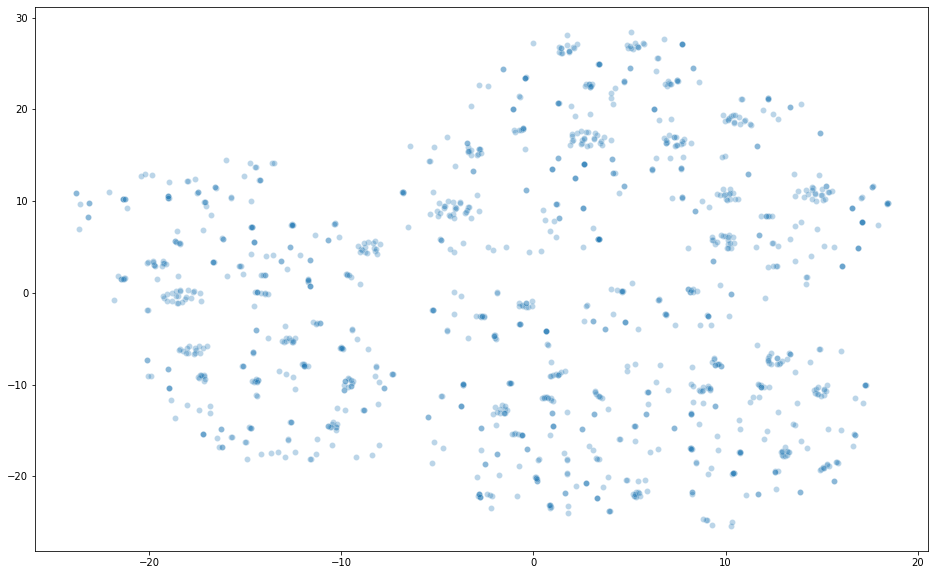

In [20]:
# Scale data
users_train_scaled = pd.DataFrame(data=MinMaxScaler().fit_transform(users_train), index=users_train.index, columns=users_train.columns)

# Calculate t-sne components
tsne = TSNE(n_components=2, verbose=1, perplexity=75, n_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
tsne_results = tsne.fit_transform(users_train_scaled)

# Visualize
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

### 6.2 Psychological profiles

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1229 samples in 0.001s...
[t-SNE] Computed neighbors for 1229 samples in 0.193s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1229
[t-SNE] Computed conditional probabilities for sample 1229 / 1229
[t-SNE] Mean sigma: 0.674982
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.294304
[t-SNE] KL divergence after 1000 iterations: 1.470554


<AxesSubplot:>

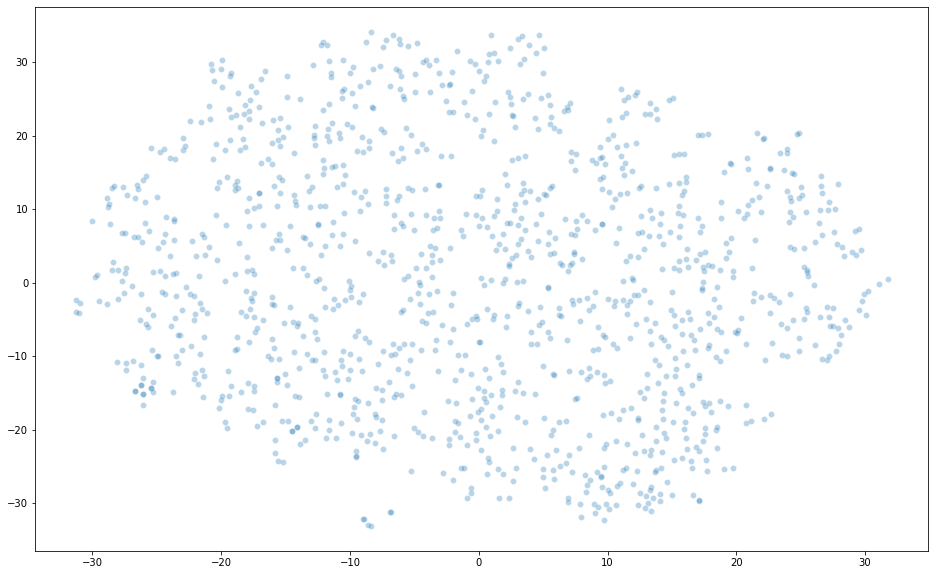

In [21]:
# Scale data
profiles_train_scaled = pd.DataFrame(data=StandardScaler().fit_transform(profiles_train), index=profiles_train.index, columns=profiles_train.columns)

# Calculate t-sne components
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
tsne_results = tsne.fit_transform(profiles_train_scaled)

# Visualize
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

Psychological profiles are very fuzzy and have low density. There are no easy separable clusters. It might be hard to find connection between demographic and psychological data.

## 7. Connection between datasets

### 7.1 Latent approach
Even though psychological profiles have no dense clusters (profiles are fuzzy), as first step we'll try to build neural network that fits to vector of psychological profile. In this case we'll reduce our feature space to 1D vector with the same shape as psychological profile and try to minimize loss which will be MSE loss between those two vectors. In the future cosine metric should be investigated as well but due to limitations of time, we'll keep working with one approach.

#### 7.1.1 Config

In [22]:
INPUT_SIZE = users_train.shape[1]
OUTPUT_SIZE = profiles_train.shape[1]

N_EPOCHS = 100
BATCH_SIZE = 128
LR = 0.001

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 7.1.2 Net, dataloader etc. configuration

In [23]:
# Scale test data
users_test_scaled = pd.DataFrame(data=MinMaxScaler().fit_transform(users_test), index=users_test.index, columns=users_test.columns)

# Merge data
df_train = pd.merge(
    left=users_train_scaled, 
    right=profiles_train,
    how='inner',
    left_index=True,
    right_index=True
)
df_test = pd.merge(
    left=users_test_scaled, 
    right=profiles_test,
    how='inner',
    left_index=True,
    right_index=True
)

# Initialize Datasets
ds_train = UsersProfilesDataset(df_train)
ds_test = UsersProfilesDataset(df_test)

# Initialize Sampler
sampler = torch.utils.data.RandomSampler(ds_train)

# Initialize DataLoader
train_dl = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, sampler=sampler)
test_dl = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE)

# Model params
net = ProfileClassifier(INPUT_SIZE, OUTPUT_SIZE).to(DEVICE)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

#### 7.1.3 Evaluation function

In [24]:
@torch.no_grad()
def evaluate_model(model, data_loader, print_info=False):
    
    model.eval()
    collect_results = []
    collect_targets = []

    for batch in data_loader:
        X, y = batch
        X = X.float().to(DEVICE)
        y = y.float().to(DEVICE).detach().cpu().numpy()

        pred = model(X)
        collect_results.append(pred.detach().cpu().numpy())
        collect_targets.append(y)

    preds = np.concatenate(collect_results)
    targets = np.concatenate(collect_targets)

    mse = mean_squared_error(targets, preds)

    if print_info:
        print(f'test mse: {mse}')

    model.train()
        
    return mse

#### 7.1.4 Train loop

In [25]:
losses = []
metrics = []

net.to(DEVICE)

for epoch in range(N_EPOCHS):
    print(f'EPOCH={epoch + 1}')
    for X, y in train_dl:
        X = X.float().to(DEVICE)
        y = y.float().to(DEVICE)
        optimizer.zero_grad()
        
        y_pred = net(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().cpu().numpy())
        
    train_ll = evaluate_model(net, train_dl)
    test_ll = evaluate_model(net, test_dl)
    
    print(f'train: loss={train_ll}')
    print(f'test: loss={test_ll}')
          
    metrics.append([train_ll, test_ll])

EPOCH=1
train: loss=0.7238178253173828
test: loss=0.7090197801589966
EPOCH=2
train: loss=0.717643141746521
test: loss=0.7047283053398132
EPOCH=3
train: loss=0.7120188474655151
test: loss=0.7011834383010864
EPOCH=4
train: loss=0.7055439949035645
test: loss=0.6975440979003906
EPOCH=5
train: loss=0.6972784399986267
test: loss=0.6938810348510742
EPOCH=6
train: loss=0.685458779335022
test: loss=0.6901108026504517
EPOCH=7
train: loss=0.6713173985481262
test: loss=0.6865708231925964
EPOCH=8
train: loss=0.6526302695274353
test: loss=0.6838923692703247
EPOCH=9
train: loss=0.6369100213050842
test: loss=0.6842153668403625
EPOCH=10
train: loss=0.6235559582710266
test: loss=0.6845375895500183
EPOCH=11
train: loss=0.6162261962890625
test: loss=0.6845813393592834
EPOCH=12
train: loss=0.6101564764976501
test: loss=0.6840032339096069
EPOCH=13
train: loss=0.6055840253829956
test: loss=0.6820155382156372
EPOCH=14
train: loss=0.6028091907501221
test: loss=0.6805928349494934
EPOCH=15
train: loss=0.59735643

<AxesSubplot:>

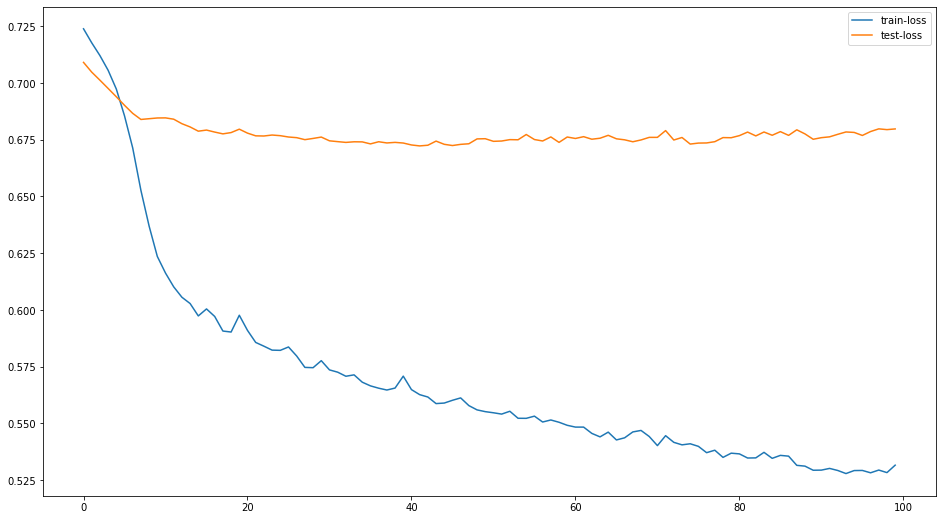

In [26]:
# Plot train/test loss through epochs
%matplotlib inline
pd.DataFrame(metrics, columns=['train-loss','test-loss']).plot(subplots=False, figsize=(16,9))

After many attemps of modifying network architecture and hyperparameters we had no satisfying results. As we assumed from investigating psychological profiles in 2 dimensionality space they're quite sparsed and it's hard to find a mapping method that significantly reduces our loss function. With this method improvement of training is very low and we'll continue with another approaches.

### 7.2 Clustering approach

In this approach we'll cluster our users by demographic features to identify groups of similar users. And then we'll investigate differences between 5 psychological features between those groups. Due to fact that we have mixed-type data, we'll perform clustering using KPrototype method. Due limitations of time we'll not try another ones - hierarchical and density-based (DBSCAN) methods base on gower distance matrix.

<function matplotlib.pyplot.show(close=None, block=None)>

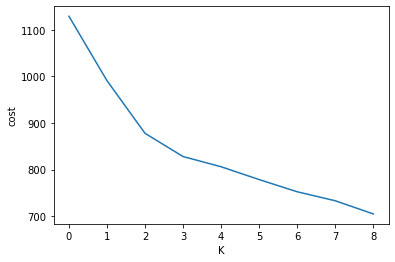

In [65]:
# Calculate cost function for each variation of k parameter (number of clusters)
cost = []
for num_clusters in range(1, 10):
    kproto = KPrototypes(
        n_clusters=num_clusters, 
        init='Cao', # 'Huang'
        random_state=RANDOM_STATE,
        n_jobs=-1,
        max_iter=100,
        n_init=50
    ) 
    kproto.fit_predict(users_train_scaled, categorical=[*range(1, 31)])
    cost.append(kproto.cost_)

# Plot results
plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In this case, based on our knowledge and data insights, we'll proceed with k=3 clusters (please notice that graph has index started from 0).

In [28]:
# Perform clustering with chosen k parameter
k_final = 3

kproto = KPrototypes(
    n_clusters=k_final, 
    init='Cao', # 'Huang'
    random_state=RANDOM_STATE,
    n_jobs=-1,
    max_iter=100,
    n_init=50
)
clusters = kproto.fit_predict(users_train_scaled, categorical=[*range(1, 31)])

Now, let's visualize our results. How well our user groups were distinguished.

[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 1229 samples in 0.003s...
[t-SNE] Computed neighbors for 1229 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1229
[t-SNE] Computed conditional probabilities for sample 1229 / 1229
[t-SNE] Mean sigma: 0.935139
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.076874
[t-SNE] KL divergence after 1000 iterations: 0.865928


<AxesSubplot:>

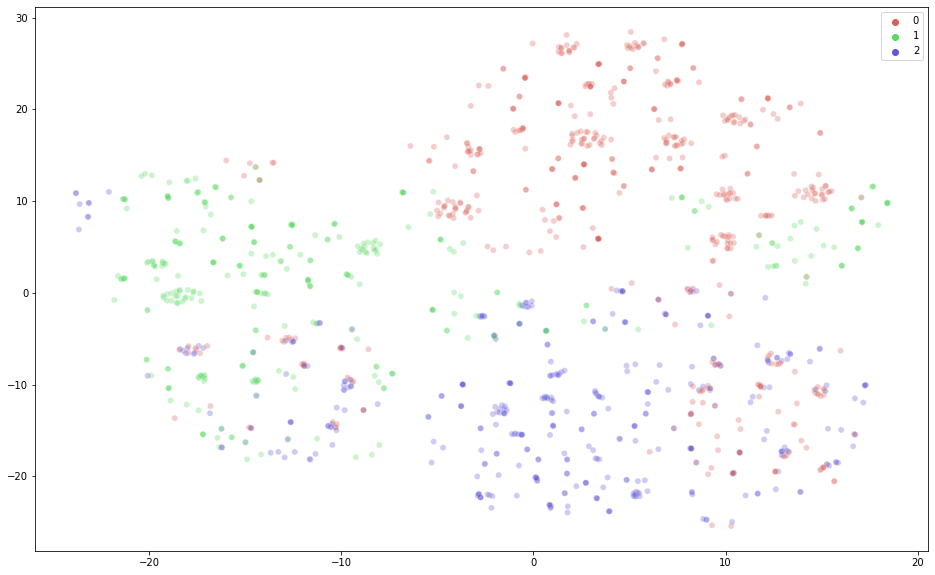

In [29]:
# Calculate t-sne components
tsne = TSNE(n_components=2, verbose=1, perplexity=75, n_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
tsne_results = tsne.fit_transform(users_train_scaled)

# Visualize
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=clusters,
    palette=sns.color_palette("hls", k_final),
    legend="full",
    alpha=0.3
)

Our results are not perfect - we have some overlapping among our clusters. But in general we can notice main patterns in our data. Let's see how our clustering results based on demographic data looks for psychological profiles. We'll visualize those clusters on our 2nd dataset.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1229 samples in 0.001s...
[t-SNE] Computed neighbors for 1229 samples in 0.104s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1229
[t-SNE] Computed conditional probabilities for sample 1229 / 1229
[t-SNE] Mean sigma: 0.674982
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.294304
[t-SNE] KL divergence after 1000 iterations: 1.470554


<AxesSubplot:>

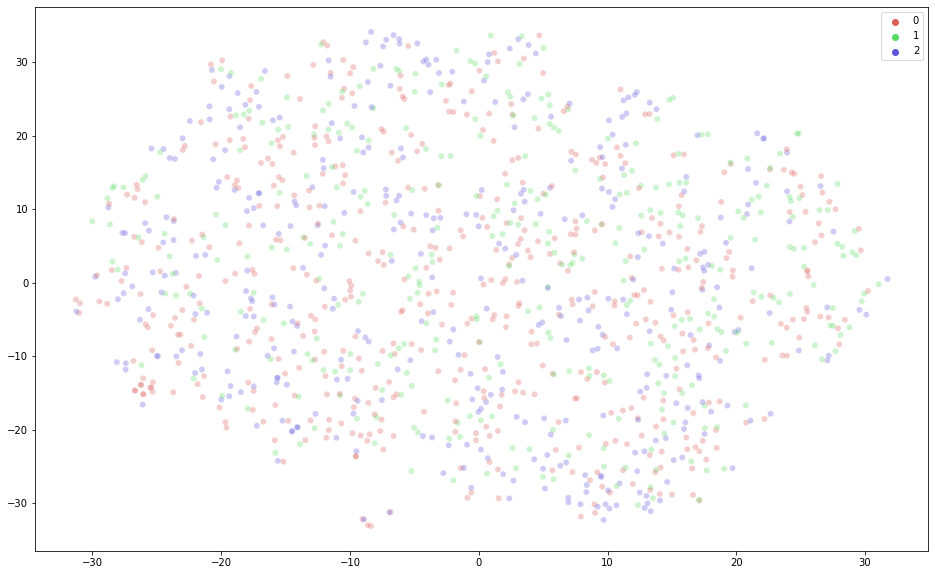

In [30]:
# Calculate t-sne components
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
tsne_results = tsne.fit_transform(profiles_train_scaled)

# Visualize
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=clusters,
    palette=sns.color_palette("hls", k_final),
    legend="full",
    alpha=0.3
)

With this method our we have similar results as with neural network - there is no clear and perfect way to describe users' psychological profile by few quite general information. With this visualization connection is not very clear (even though it exists). Let's try to compare each psychological component per our users' groups.

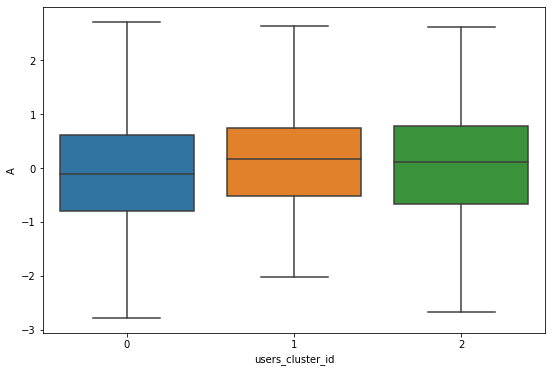

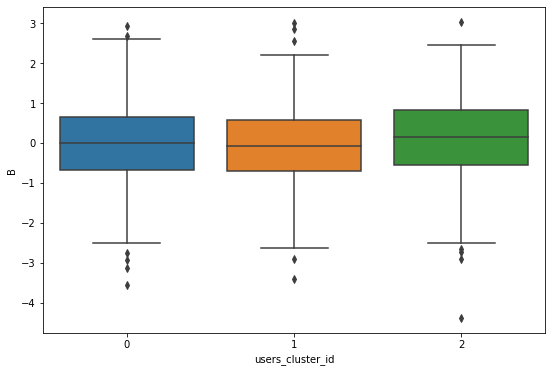

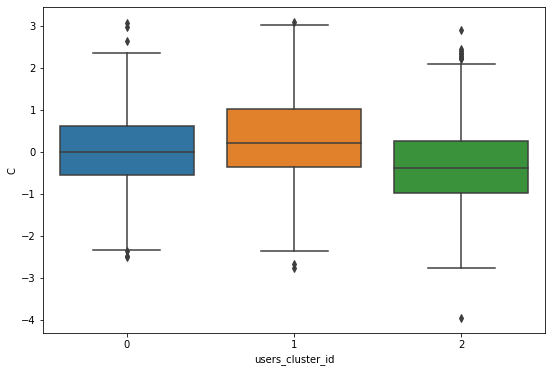

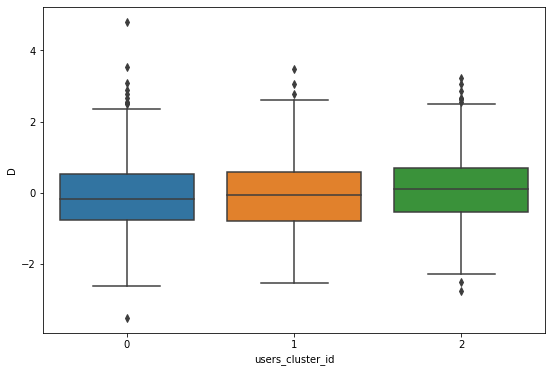

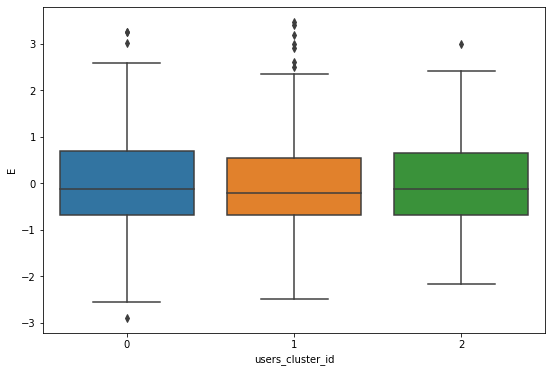

In [31]:
profiles_train_scaled_copy = profiles_train_scaled.copy()
profiles_train_scaled_copy['users_cluster_id'] = clusters

for col in [x for x in profiles_train_scaled_copy.columns if x != 'users_cluster_id']:
    plt.figure(figsize=(9, 6))
    sns.boxplot(
        data=profiles_train_scaled_copy,
        x='users_cluster_id',
        y=col
    )
    plt.show()

With this way of visualization we can notice that even though connection is not very strong, there are some patterns and different distribution of psychological profiles among our groups of users. We cannot interpret those data because no additional information were provided (what factors A-E means).

## 8. Clustering

In this section we'll perform clustering of psychological profiles and then describe profiles of users (in terms of demographic data).
We're dealing with continuous features so in this case we'll perform clustering using kmeans algorithm. Other methods were not tested due to limitations of time.

### 8.1 Data preparation

In [32]:
# Merge train and test results of psychological profiles
profiles_train_scaled = pd.DataFrame(data=StandardScaler().fit_transform(profiles_train), index=profiles_train.index, columns=profiles_train.columns)
profiles_test_scaled = pd.DataFrame(data=StandardScaler().fit_transform(profiles_test), index=profiles_test.index, columns=profiles_test.columns)

profiles_scaled = pd.concat([profiles_train_scaled, profiles_test_scaled], axis=0)

### 8.2 Searching for optimal number of clusters

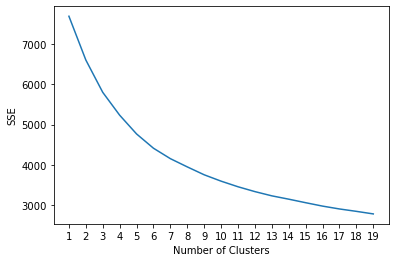

In [33]:
# Set kmeans hyperparameters
kmeans_kwargs = {
    'init': 'random',
    'n_init': 100,
    'max_iter': 2000,
    'random_state': RANDOM_STATE,
}

# Calculate SSE for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(profiles_scaled)
    sse.append(kmeans.inertia_)
    
# Plot results
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

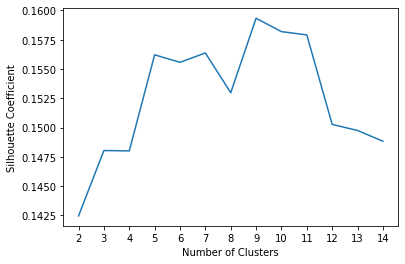

In [34]:
# Calculate silhouette coefficients for each k
silhouette_coefficients = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(profiles_scaled)
    score = silhouette_score(profiles_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)
    
# Plot results
plt.plot(range(2, 15), silhouette_coefficients)
plt.xticks(range(2, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Based on SSE and sillhouette coefficient for each variation of k parameter, we'll pick k=5 as optimal number of clusters. Decision was based on those 'metrics' and experience - it would be easier to proceed in next steps which is finding patterns in demographic data among those groups.

### 8.3 Perform clustering with selected k

In [35]:
# Perform k-means with optimal number of clusters
k_final = 5
kmeans = KMeans(n_clusters=k_final, **kmeans_kwargs)
kmeans.fit(profiles_scaled)

KMeans(init='random', max_iter=2000, n_clusters=5, n_init=100, random_state=42)

### 8.4 2D visualization of clusters

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1537 samples in 0.001s...
[t-SNE] Computed neighbors for 1537 samples in 0.113s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1537
[t-SNE] Computed conditional probabilities for sample 1537 / 1537
[t-SNE] Mean sigma: 0.639023
[t-SNE] KL divergence after 150 iterations with early exaggeration: 71.963959
[t-SNE] KL divergence after 1000 iterations: 1.547702


<AxesSubplot:>

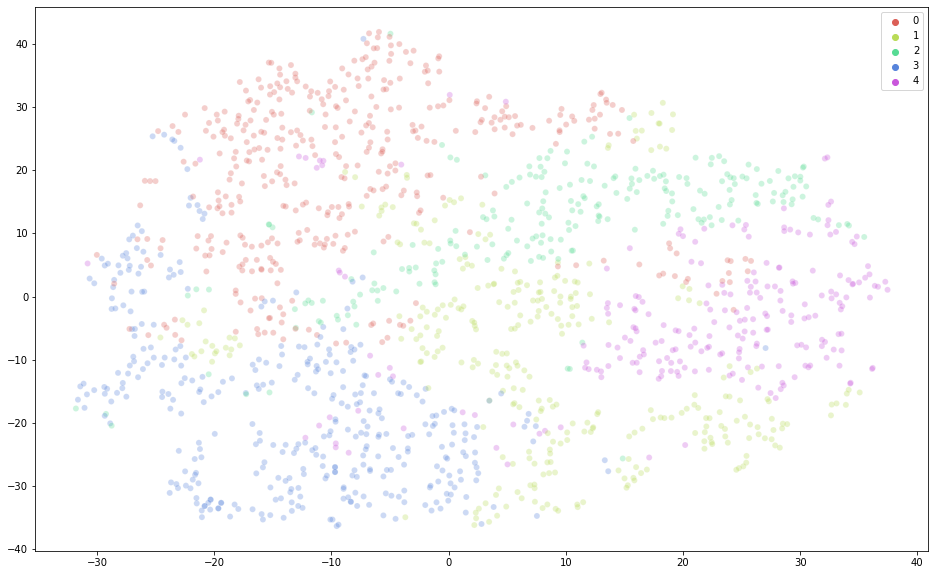

In [36]:
# Calculate t-sne components
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
tsne_results = tsne.fit_transform(profiles_scaled)

# Visualize
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=kmeans.labels_,
    palette=sns.color_palette("hls", k_final),
    legend="full",
    alpha=0.3
)

### 8.5 Cluster characteristics

#### 8.5.1 Prepare data

In [37]:
users_not_transformed = pd.concat([users_train_not_transformed, users_test_not_transformed], axis=0)

profiles_scaled['cluster_id'] = kmeans.labels_

df_users_profiles_clust = pd.merge(
    left=users_not_transformed,
    right=profiles_scaled,
    how='inner',
    left_index=True,
    right_index=True
) 

df_users_profiles_clust.head()

,D01,D03,D04,D05,D06,D07,browser_name,device_type,age,browser_version_rank,A,B,C,D,E,cluster_id
UserIdentifier,,,,,,,,,,,,,,,,
000d192dc28d1b486121e036a9dbdad6,K,4.0,3.0,5.0,4.0,3.0,Chrome,Desktop,20,7.0,-0.028996,1.066158,1.236810,0.209477,0.017088,1
0013bf1a1aacd3adabe31f48af5c32b5,K,3.0,3.0,5.0,7.0,4.0,Chrome,Mobile,22,25.0,0.172452,0.750056,2.124578,-0.519605,-0.349187,1
0030705d4aeb43d6bf58cd8df61d4499,M,2.0,4.0,2.0,3.0,3.0,Safari,Mobile,38,1.0,1.238557,0.244923,-0.369061,0.300804,-1.091945,0
005644e9eca0b367f9e0dafbdc2eed9f,K,3.0,2.0,1.0,4.0,3.0,Chrome,Desktop,25,8.0,0.678497,-0.612334,1.219896,1.912856,0.793291,2
005ae7d7a05669373b74fe35a025cdd0,M,3.0,4.0,3.0,5.0,3.0,Firefox,Desktop,35,2.0,2.379464,-0.988891,0.010380,1.746602,0.055934,2


#### 8.5.2 Plot results

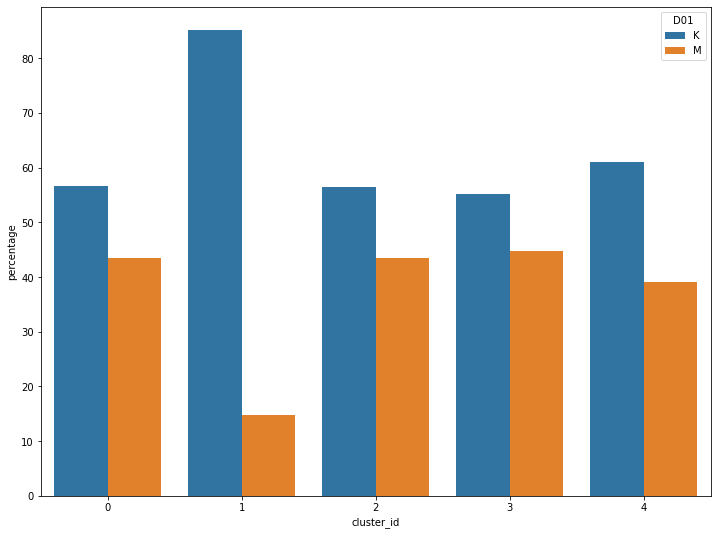

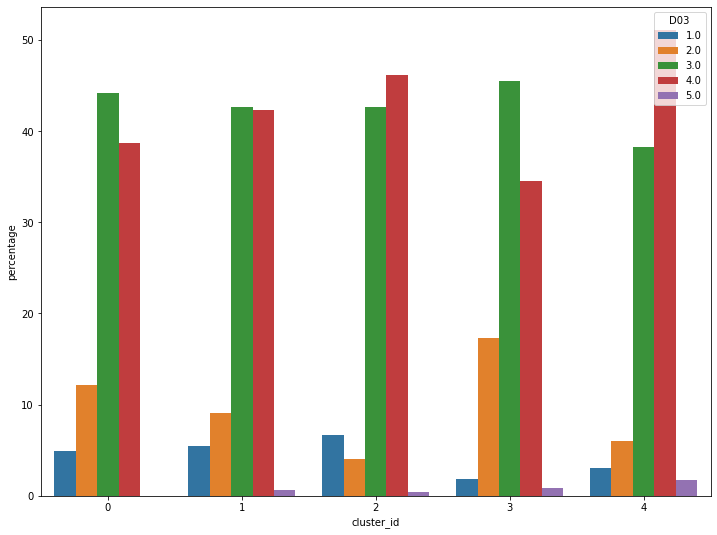

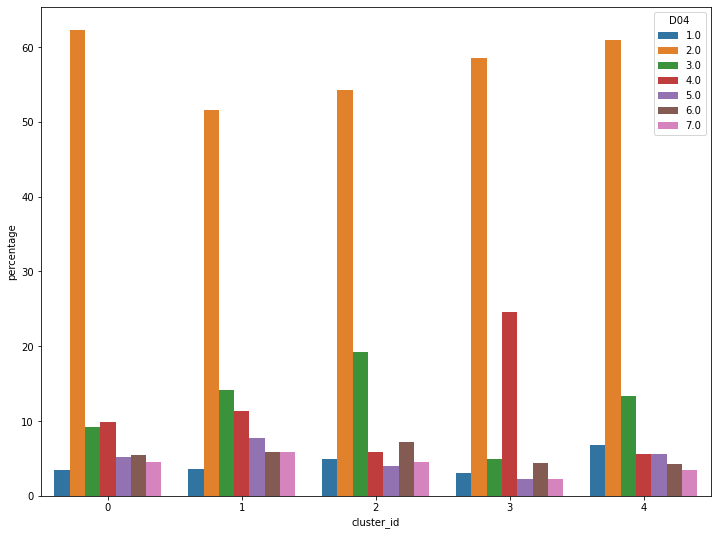

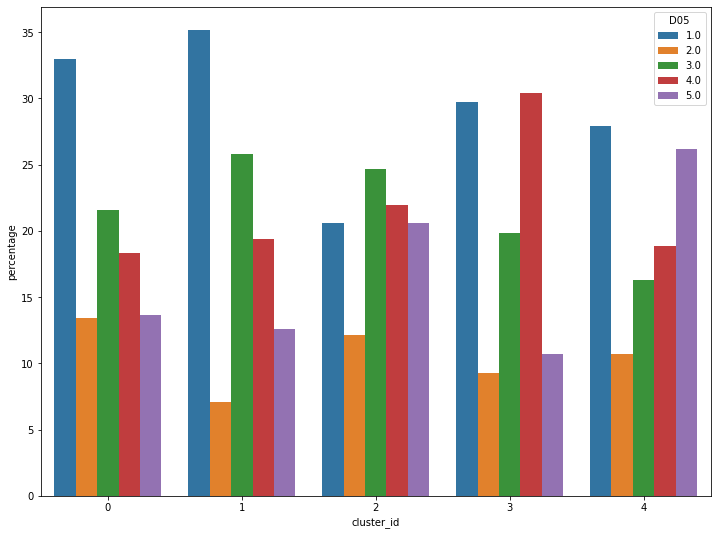

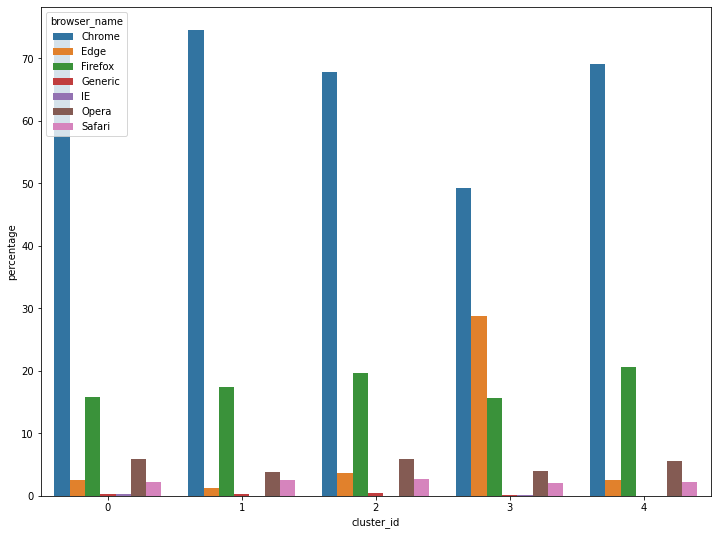

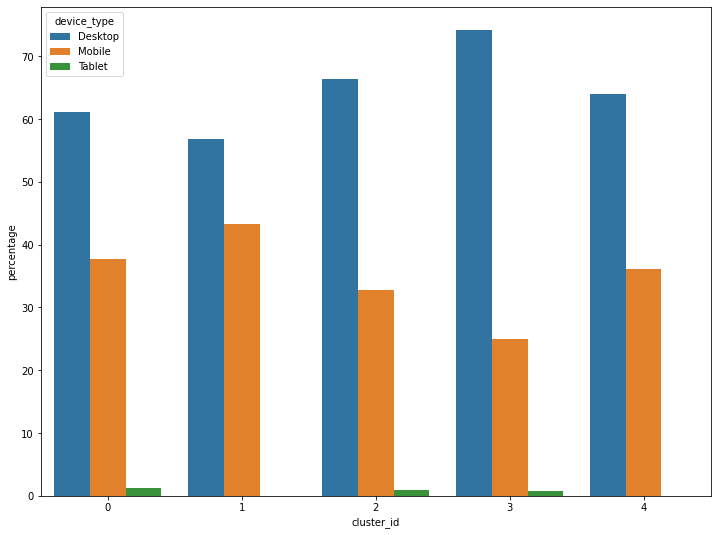

In [64]:
categorical_features = [
    x for x in df_users_profiles_clust.columns if x not in ['age', 'D06', 'D07', 'browser_version_rank'] + ['A', 'B', 'C', 'D', 'E'] + ['cluster_id']
]

for col in categorical_features:
    plt.figure(figsize=(12,9))
    temp = (df_users_profiles_clust.groupby(['cluster_id'])[col]
        .value_counts(normalize=True)
        .rename('percentage')
        .mul(100)
        .reset_index()
        .sort_values(col))
    ax = sns.barplot(x='cluster_id', y='percentage', hue=col, data=temp)
    plt.show()

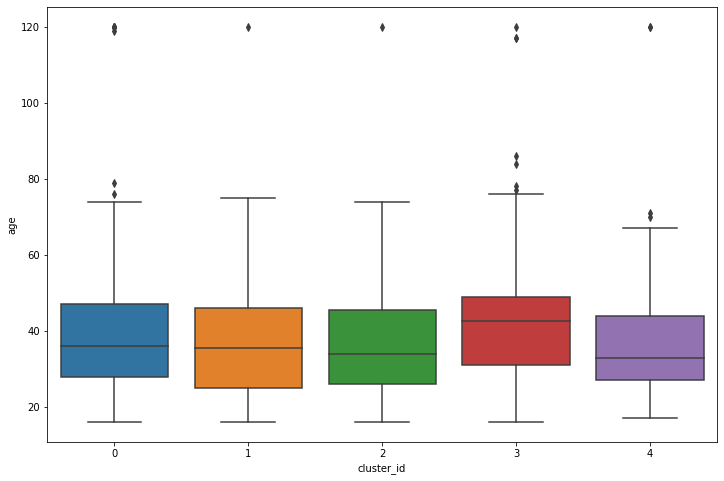

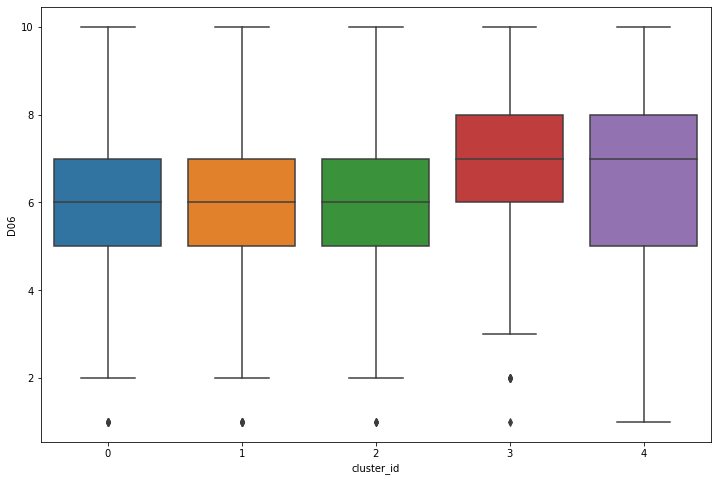

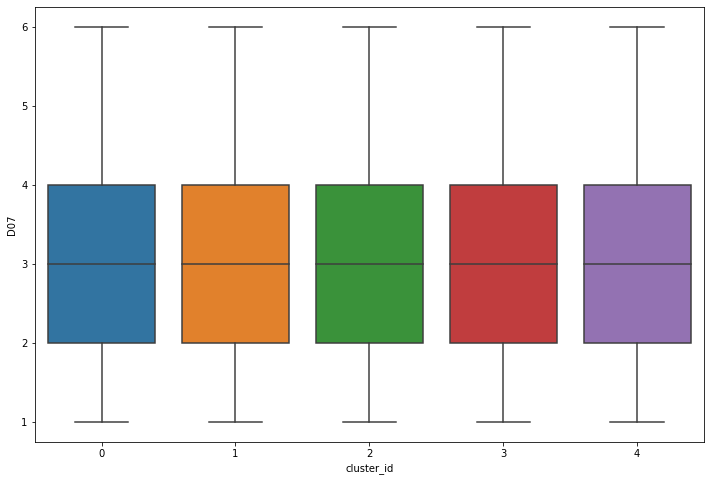

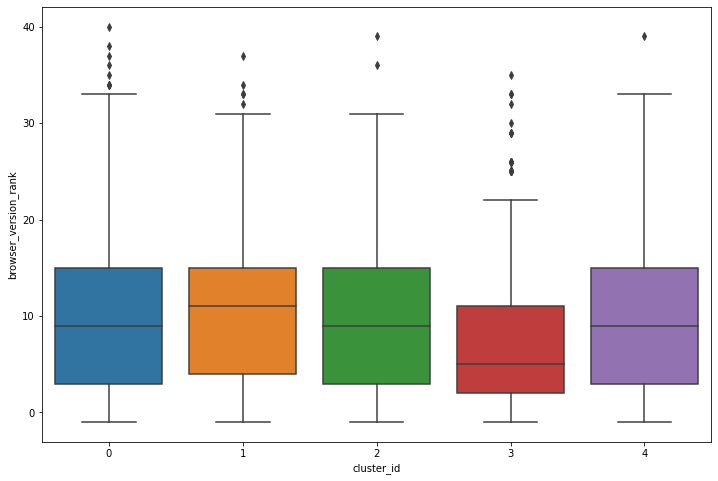

In [42]:
for col_name in ['age', 'D06', 'D07', 'browser_version_rank']:
    plt.figure(figsize=(12,8))
    sns.boxplot(
        data=df_users_profiles_clust,
        x='cluster_id',
        y=col_name
    )
    plt.show()

#### 8.5.3 Demographic description of psychological profiles (clusters)

## 9. Conclusions and summary